In [109]:
#importing modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DayLocator, DateFormatter
import datetime as dt
from sklearn import preprocessing
from matplotlib.dates import HourLocator, DateFormatter

In [110]:
nov_5 = pd.read_csv('/Users/varungandhi/Desktop/eddypro_data/nov/eddy_out_5/eddypro_csat_full_output_2022-03-11T141139_exp.csv',
                    header=[1,2])
nov_5.columns = nov_5.columns.map('_'.join)

nov_30 = pd.read_csv('/Users/varungandhi/Desktop/eddypro_data/nov/eddy_out/eddypro_csat_full_output_2022-03-11T140658_exp.csv',
                    header=[1,2])
nov_30.columns = nov_30.columns.map('_'.join)

In [111]:
nov_5['TIMESTAMP']  = nov_5['date_[yyyy-mm-dd]'].astype(str)+" "+ nov_5['time_[HH:MM]'].astype(str)
nov_5['TIMESTAMP']  = pd.to_datetime(nov_5['TIMESTAMP'])

nov_30['TIMESTAMP']  = nov_30['date_[yyyy-mm-dd]'].astype(str)+" "+ nov_30['time_[HH:MM]'].astype(str)
nov_30['TIMESTAMP']  = pd.to_datetime(nov_30['TIMESTAMP'])

In [112]:
h_5 = []
l_5 = []
for i in range(len(nov_5['H_[W+1m-2]'])):
    if nov_5['H_[W+1m-2]'][i] < -9000:
        h_5.append(float('NAN'))
    else:
        h_5.append(nov_5['H_[W+1m-2]'][i])
        
for i in range(len(nov_5['LE_[W+1m-2]'])):
    if nov_5['LE_[W+1m-2]'][i] < -9000:
        l_5.append(float('NAN'))
    else:
        l_5.append(nov_5['LE_[W+1m-2]'][i])
nov_5['H_[W+1m-2]'] = np.array(h_5)
nov_5['LE_[W+1m-2]'] = np.array(l_5)

In [113]:
h_30 = []
l_30 = []
for i in range(len(nov_30['H_[W+1m-2]'])):
    if nov_30['H_[W+1m-2]'][i] < -9000:
        h_30.append(float('NAN'))
    else:
        h_30.append(nov_30['H_[W+1m-2]'][i])
        
for i in range(len(nov_30['LE_[W+1m-2]'])):
    if nov_30['LE_[W+1m-2]'][i] < -9000:
        l_30.append(float('NAN'))
    else:
        l_30.append(nov_30['LE_[W+1m-2]'][i])
nov_30['H_[W+1m-2]'] =  np.array(h_30)
nov_30['LE_[W+1m-2]'] = np.array(l_30)

In [114]:
nov_5 = nov_5.resample('30T',label = 'right', on = 'TIMESTAMP', closed = 'right').mean()
nov_5.reset_index(inplace= True)

In [115]:
merge = pd.merge(nov_30,nov_5,on = 'TIMESTAMP', how = 'left')

In [116]:
merge['H_[W+1m-2]_x'][:534]

0      66.3534
1      67.7421
2      75.9257
3      64.0643
4      44.1892
        ...   
529    34.6588
530    48.9154
531    68.3041
532    14.5332
533    11.6813
Name: H_[W+1m-2]_x, Length: 534, dtype: float64

In [117]:
merge['H_[W+1m-2]_y']

0      72.301000
1      69.489100
2      72.569583
3      66.713450
4      45.276367
         ...    
530    44.083717
531    66.426617
532    18.249843
533    11.486395
534     5.505232
Name: H_[W+1m-2]_y, Length: 535, dtype: float64

In [118]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope

lof1 = LocalOutlierFactor()
X = merge['H_[W+1m-2]_x'][:534].values.reshape(-1,1)
Y = merge['H_[W+1m-2]_y'][:534].values.reshape(-1,1)

Y_pred = lof1.fit_predict(X)
mask1 = Y_pred != -1
X, Y = X[mask1], Y[mask1]

model1 = LinearRegression(fit_intercept= False)
model1.fit(X, Y)
Y_pred = model1.predict(X)


lof2 = LocalOutlierFactor()
Xx = merge['u*_[m+1s-1]_x'][:534].values.reshape(-1,1)
Yy = merge['u*_[m+1s-1]_y'][:534].values.reshape(-1,1)

Yy_pred = lof2.fit_predict(Xx)
mask2 = Yy_pred != -1
Xx, Yy = Xx[mask2], Yy[mask2]


model2 = LinearRegression(fit_intercept= False)
model2.fit(Xx, Yy)
Yy_pred = model2.predict(Xx)

lof3 = EllipticEnvelope(contamination=0.01)
Xxx = merge['Tau_[kg+1m-1s-2]_x'][:534].values.reshape(-1,1)
Yyy = merge['Tau_[kg+1m-1s-2]_y'][:534].values.reshape(-1,1)

Yyy_pred = lof3.fit_predict(Xxx)
mask3 = Yyy_pred != -1
Xxx, Yyy = Xxx[mask3], Yyy[mask3]


model3 = LinearRegression(fit_intercept= False)
model3.fit(Xxx, Yyy)
# evaluate the model
Yyy_pred = model3.predict(Xxx)


In [144]:
lof4 = IsolationForest(contamination=0.1)
Xxxx = merge['LE_[W+1m-2]_x'][:534].values
Yyyy = merge['LE_[W+1m-2]_y'][:534].values
df = pd.DataFrame(Xxxx, Yyyy)
df['1'] = df.index
df = df.dropna()
x1 = df.iloc[:,0].values.reshape(-1,1)
y1 = df.iloc[:,1].values.reshape(-1,1)
y1_pred = lof4.fit_predict(x1)
mask4 = y1_pred != -1
x1, y1 = x1[mask4], y1[mask4]

model4 = LinearRegression(fit_intercept= False)
model4.fit(x1, y1)
y1_pred = model1.predict(x1)

#Yyyy.shape
df.columns

Index([0, '1'], dtype='object')

In [145]:
print('slope:', model4.coef_)
print('intercept:', model4.intercept_)
print('coefficient of determination:', model4.score(Xxx,Yyy))

slope: [[0.91903515]]
intercept: 0.0
coefficient of determination: 0.8372432510204878


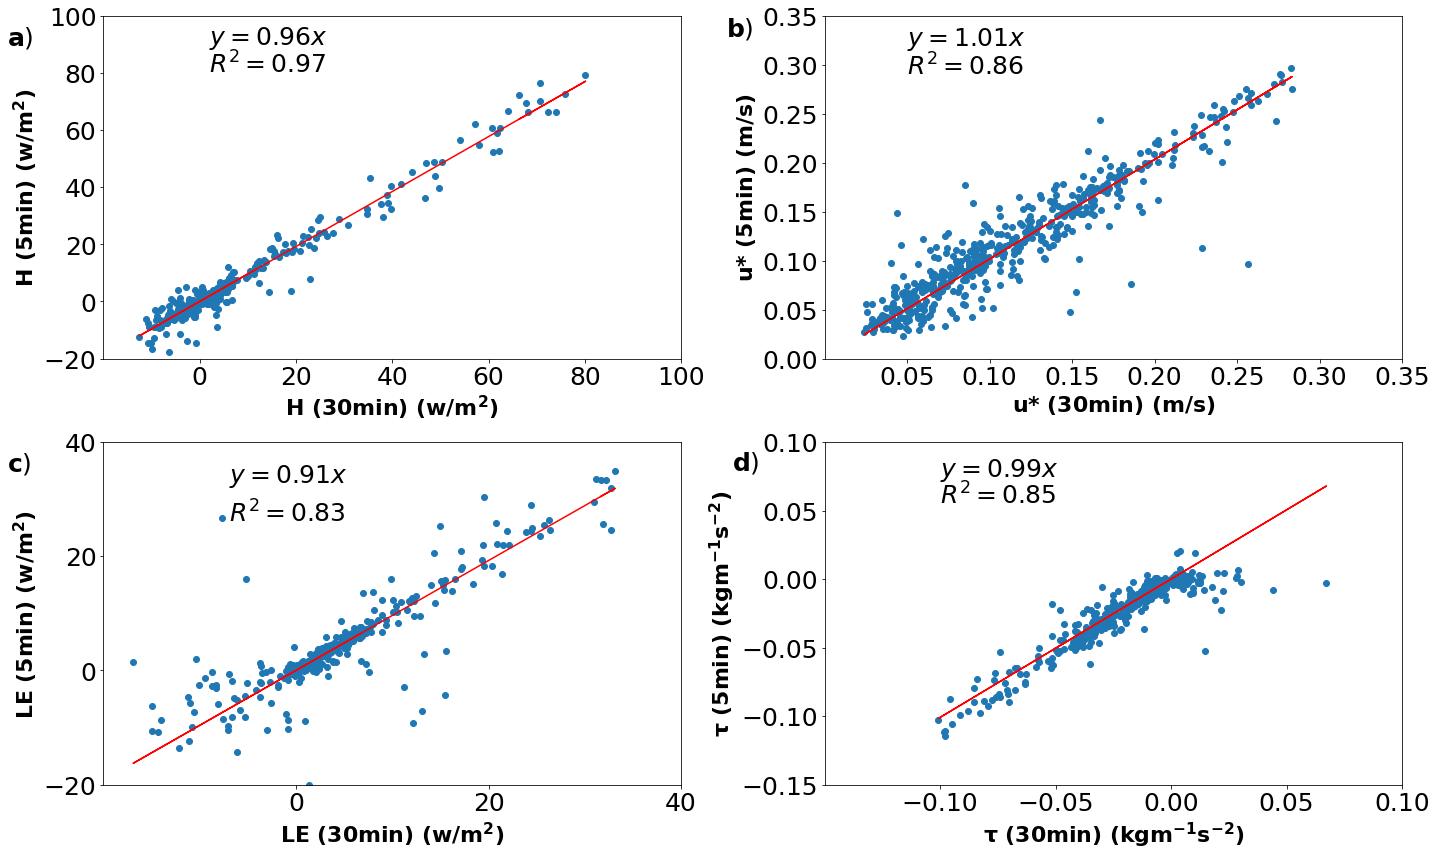

In [160]:
fig,ax = plt.subplots(2,2, figsize = (20,12))
ax[0][0].scatter(X,Y)
ax[0][0].plot(X, Y_pred, color='red')
ax[0][0].set_xlabel('H (30min) $\mathbf{(w/m^2)}$',fontsize = 22,fontweight = 'bold')
ax[0][0].set_ylabel('H (5min) $\mathbf{(w/m^2)}$', fontsize = 22 ,fontweight = 'bold')
ax[0][0].set_ylim([-20,100])
ax[0][0].set_xlim([-20,100])
ax[0][0].set_xticks(np.arange(0,101,20))
ax[0][0].text(2.0, 80, r'$R^2 = 0.97$',  fontsize = 25)
ax[0][0].text(2.0, 90, r'$y = 0.96x$', fontsize = 25)
ax[0][0].text(-40,90, r'$\mathbf{a})$', fontsize = 25)

ax[0][1].scatter(Xx, Yy)
ax[0][1].plot(Xx, Yy_pred, color='red')
ax[0][1].set_xlabel('u* (30min) $\mathbf{(m/s)}$',fontsize = 22, fontweight = 'bold')
ax[0][1].set_ylabel('u* (5min) $\mathbf{(m/s)}$', fontsize = 22 ,fontweight = 'bold')
ax[0][1].set_ylim([0,0.35])
ax[0][1].set_xlim([0,0.35])
ax[0][1].set_xticks(np.arange(0.05,0.36,0.05))
ax[0][1].set_yticks(np.arange(0.,0.36,0.05))
ax[0][1].text(0.05, 0.29, r'$R^2 = 0.86$',  fontsize = 25)
ax[0][1].text(0.05, 0.32, r'$y = 1.01x$', fontsize = 25)
ax[0][1].text(-0.06,.33, r'$\mathbf{b})$', fontsize = 25)


ax[1][1].scatter(Xxx,Yyy)
ax[1][1].plot(Xxx, Yyy_pred, color='red')
ax[1][1].set_xlabel('$\mathbf{τ\ (30min)\ (kg m^{-1}s^{-2})}$', fontsize = 22)
ax[1][1].set_ylabel('$\mathbf{τ\ (5min)\ (kg m^{-1}s^{-2})}$',  fontsize = 22)
ax[1][1].set_ylim([-0.15,0.1])
ax[1][1].set_xlim([-0.15,0.1])
ax[1][1].set_yticks(np.arange(-0.15,0.11,0.05))
ax[1][1].set_xticks(np.arange(-0.1,0.11,0.05))
ax[1][1].text(-0.1, 0.055, r'$R^2 = 0.85$',  fontsize = 25)
ax[1][1].text(-0.1, 0.075, r'$y = 0.99x$', fontsize = 25)
ax[1][1].text(-0.19,0.08, r'$\mathbf{d})$', fontsize = 25)


ax[1][0].scatter(x1, y1)
ax[1][0].plot(x1, y1_pred, color='red')
ax[1][0].set_xlabel('$\mathbf{LE\ (30min)\ (w/m^2)}$',fontsize = 22, fontweight = 'bold')
ax[1][0].set_ylabel('$\mathbf{LE\ (5min)\ (w/m^2)}$', fontsize = 22 ,fontweight = 'bold')
ax[1][0].set_ylim([-20,40])
ax[1][0].set_xlim([-20,40])
ax[1][0].set_yticks(np.arange(-20,41,20))
ax[1][0].set_xticks(np.arange(0,41,20))
ax[1][0].text(-7, 26, r'$R^2 = 0.83$',  fontsize = 25)
ax[1][0].text(-7, 33, r'$y = 0.91x$', fontsize = 25)
ax[1][0].text(-30,35, r'$\mathbf{c})$', fontsize = 25)

for axi in (ax[0][0],ax[0][1],ax[1][0],ax[1][1]):
    axi.tick_params(axis='x', which='both', labelsize=25)
    axi.tick_params(axis='y', which='both', labelsize=25)
    
fig.tight_layout()

In [149]:
#print('slope:', reg_1.coef_)
#print('intercept:', reg_1.intercept_)
#print('coefficient of determination:', reg_1.score(X,Y))

Text(0, 0.5, 'u_5m')

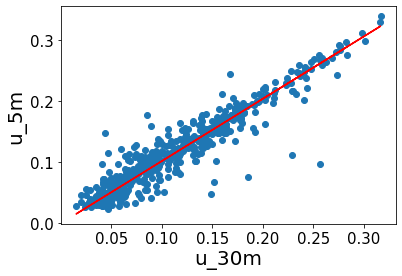

In [97]:
reg_2 = LinearRegression(fit_intercept= False)
X = merge['u*_[m+1s-1]_x'][:534].values.reshape(-1,1)
Y = merge['u*_[m+1s-1]_y'][:534].values.reshape(-1,1)
reg_2.fit(X, Y)
reg_2.coef_[0][0]

Y_pred = reg_2.predict(X)

plt.scatter(merge['u*_[m+1s-1]_x'][:534],merge['u*_[m+1s-1]_y'][:534])
plt.plot(X, Y_pred, color='red')
plt.tick_params(axis='x', which='both', labelsize=15)
plt.tick_params(axis='y', which='both', labelsize=15)
plt.xlabel('u_30m', fontsize = 20)
plt.ylabel('u_5m', fontsize = 20)

In [98]:
print('slope:', reg_2.coef_)
print('intercept:', reg_2.intercept_)
print('coefficient of determination:', reg_2.score(X,Y))

slope: [[1.01732049]]
intercept: 0.0
coefficient of determination: 0.872604244426437


Text(0, 0.5, 'Tau_5m')

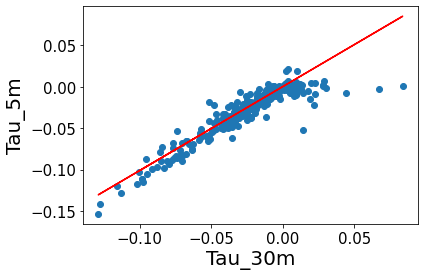

In [99]:
reg_3 = LinearRegression(fit_intercept= False)
X = merge['Tau_[kg+1m-1s-2]_x'][:534].values.reshape(-1,1)
Y = merge['Tau_[kg+1m-1s-2]_y'][:534].values.reshape(-1,1)
reg_3.fit(X, Y)
reg_3.coef_[0][0]

Y_pred = reg_3.predict(X)

plt.scatter(merge['Tau_[kg+1m-1s-2]_x'][:534],merge['Tau_[kg+1m-1s-2]_y'][:534])
plt.plot(X, Y_pred, color='red')
plt.tick_params(axis='x', which='both', labelsize=15)
plt.tick_params(axis='y', which='both', labelsize=15)
plt.xlabel('Tau_30m', fontsize = 20)
plt.ylabel('Tau_5m', fontsize = 20)

In [82]:
print('slope:', model3.coef_)
print('intercept:', model3.intercept_)
print('coefficient of determination:', model3.score(X,Y))

slope: [[0.99759498]]
intercept: 0.0
coefficient of determination: 0.9664235854780845


In [121]:
X_train.shape

(305, 13)

In [122]:
y_train.shape

(305,)

In [121]:
from sklearn.ensemble import IsolationForest
IsolationForest(contamination=0.1)

IsolationForest(contamination=0.1)

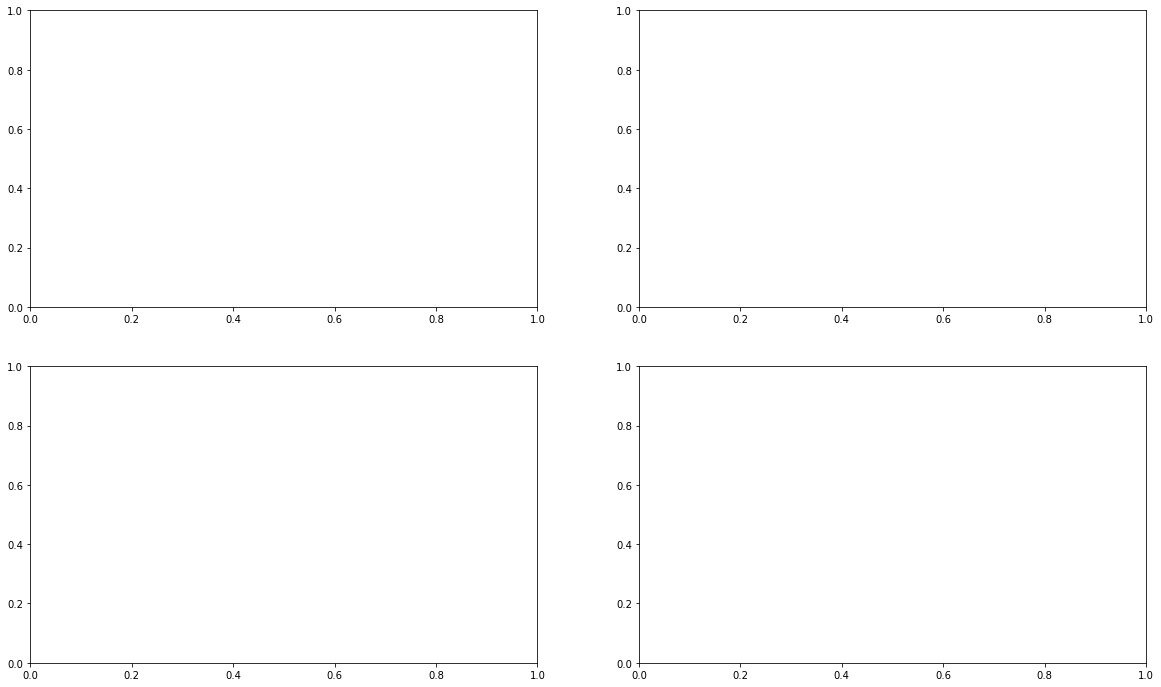

In [40]:
fig,ax = plt.subplots(2,2, figsize = (20,12))
